

# Bagging

## Bootstrap Aggregating with Random Forests

## Bagging - overview



The general idea:

* Bootstrap: sample with replacement from dataset $N$ times
* Train $N$ models on those samples
* Aggregate: combine their output

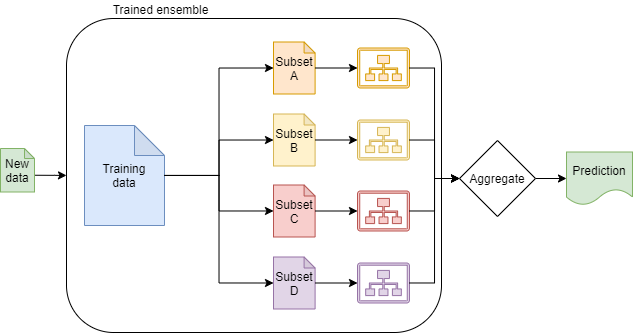



Bagging is an ensemble method. It trains many models on subsets of the dataset, then combines their output.

The combination you do depends on the type of data you have.

For classification, you take the most commonly predicted class (the mode). For regression, you take the mean of the predicted values.

The data subsets are statistically similar to the overall dataset, though it is likely that some rare items will not appear in all subsets.

The idea is that training lots of poor models and then averaging over them will result in slightly better performance.

## Bagging: target models

* The bootstrap aggregated model can join predictions of weak learners
    * Even if each individual model has a performance only slightly better than random, their joint prediction may be strong
* The base models can be unstable
    * They may have large variations in their predictions for small changes in data samples, or other factors during training
    * Typical examples: decision trees, nearest neighbours

It's important to know which kind of models ensembles are useful for.

First, it may be a weak learner. That is, its performance may be only slightly better than just randomly guessing. It's similar to "the wisdom of crowds". Imagine a question where any one person has a 51% chance of being right. If you ask one person, you get one answer with a 51% chance of it being right. But if you ask lots of people and take the most common response, you improve your chances.

The model used may be unstable. That is, given a slight change in the data, the output is very different. Logistic regression is stable: a small change in the input probably won't make much difference to the outcome. Decision trees are unstable: a small change can result in a different path taken through the tree and a very different outcome.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np

data = sklearn.datasets.load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], random_state=0)

## Bagging: implementation

In [2]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

ensemble = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=20,
    random_state=0
)
ensemble.fit(X_train, y_train);

We can use, as an example, a `DecisionTreeClassifier` algorithm, and compare it with 20 individual models, each using a different subset of the training data. What the `BaggingClassifier` does is simple: create random training subsets for each model, and fit each normally. Then aggregate the predictions.

## Bagging: performance gains

In [3]:
scores = [est.score(X_test, y_test) for est in ensemble.estimators_]

plt.bar(np.arange(len(scores))+1, scores);
plt.xlabel("Model index")
plt.xticks([1,5,10,15,20])
plt.ylabel("Accuracy")
plt.ylim(0.8,1.)

print(f"Single model accuracy: {dtc.score(X_test, y_test)}")

print(f"Average of single models accuracies: {np.mean(scores)}")

print(f"Ensemble model accuracy: {ensemble.score(X_test, y_test)}")

Here we can see the performance of a single decision tree model versus an ensemble of 20. 

The chart of the 20 models in the ensemble shows that the performance varies quite a lot depending on the input subset, demonstrating how brittle this model is for this data and sample size. Individual models with high accuracy were lucky, and selecting them alone would be using an overfit model.

Meanwhile the ensemble model has an accuracy of 0.98, which is much higher than the average the performance of individual models, 0.92.

## Bagging: data

* Bagging will generate stronger performance on data points seen often
* Rare items appear in fewer samples
    * Implicitly ignores outliers

One thing to consider is that if you have unbalanced data, then bootstrapping could result in some models being trained on subsets that do not contain any examples of the less common class.

This can be good, if you only really care about the most common class. It's also one way to ignore outliers in the data.

## Bagging: data

* Bagging will generate stronger performance on data points seen often
* Rare items appear in fewer samples
    * Implicitly ignores outliers
* Can oversample/undersample
    * Give more prominence to rarer items

But if you don't want this, then you can oversample (duplicate the rare items so that they appear in more subsets) or undersample (drop common items so they appear less often overall)

## Ensembles for uncertainty prediction

* A different use of ensembles is to estimate how reliable your predictions are for a sample.
* The variance of the predictions for a sample from all individual models tell you how certain you are of the prediction probability.
* Important for sensitive applications, as in medicine, where one needs to know not only the prediction, but also the confidence of the prediction.
* Useful also for robust models, such as neural networks, which are not brittle as decision trees.
* Reference paper: Simple and scalable predictive uncertainty estimation using deep ensembles ([Lakshminarayanan et al. 2017](https://arxiv.org/abs/1612.01474 "Predictive uncertainty"))

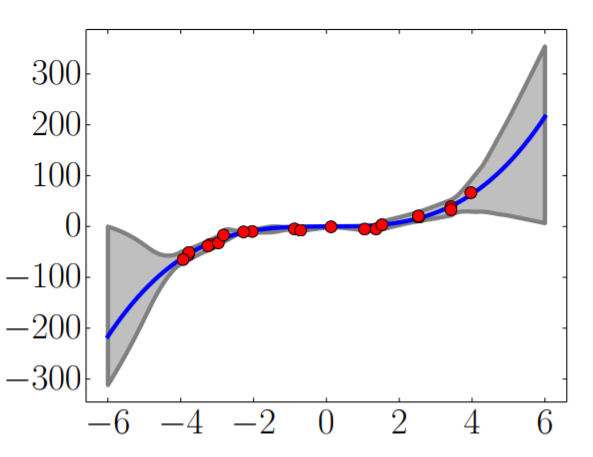

A different use of ensembles is not related to generalisation. We can use the predictions of all the individual models to estimate how sure we are about the prediction of a given sample.

Like in this regression model (taken from [this paper](https://arxiv.org/abs/1612.01474)), in blue are the predictions of the ensemble (the average of the individual predictions), while we also have the uncertainty of the predictions in gray, which is given by the variance of the predictions of the individual models.

## Random Forest: ensemble of decision trees

* Bagging is most commonly used with decision trees, and is called Random Forest
* Decisions trees are prone to overfitting and are unstable
* Features are different for different data subsets
* Easy to build diverse decision trees:
    * Subsamples the data AND the features

Decision trees are a good choice for ensembles, as they can overfit to the training data very easily, and are unstable. Using lots of decision trees in an ensemble is called a random forest.

By training trees on subsets of features, we can learn which features are the most important. This helps avoid overfitting - you don't want all the trees in the forest using the exact same very strong feature to make their decision. This could harm generalisation ability on unseen data.

### Brittleness of decision trees

* We can visualize two individual decision trees, training on the same task, with different subsets of the data.
* The split feature is already different from the starting node.

In [4]:
from sklearn import tree

plt.figure(figsize=(10,6))

dtc = ensemble.estimators_[0]

tree.plot_tree(dtc, filled=True, fontsize=10, feature_names=list(data.feature_names), max_depth = 2)

plt.figure(figsize=(10,6))

dtc = ensemble.estimators_[1]

tree.plot_tree(dtc, filled=True, fontsize=10, feature_names=list(data.feature_names), max_depth = 2)

## Random Forest - forest settings

Adding trees: reduces variance
* But no effect after a point

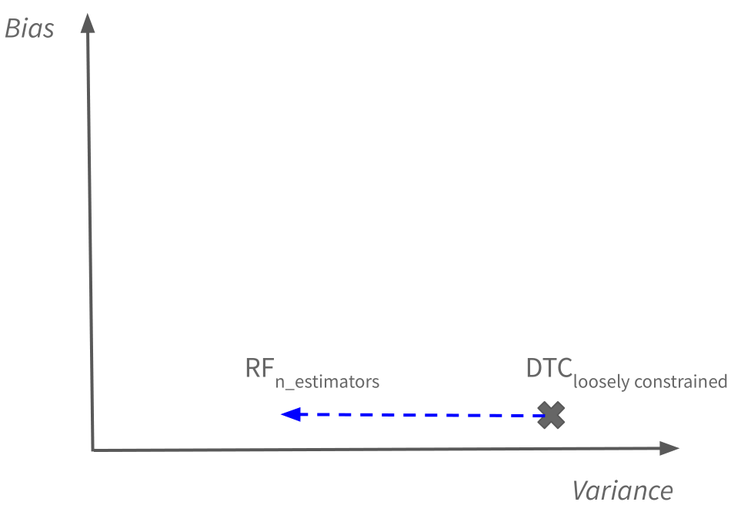



For a random forest, the main hyperparameter is how many trees to use. The more you use, the less variance your model has, which will improve performance on the training data, up to a point.

You do want to retain some variance though, for generalisability to a test set.

### Number of trees in the forest

* Diminishing return on the number of individual models
* Trade-off with computational cost of training multiple models (linear with number of models)
* A typical range for the number of trees would be 100-1000 but is highly dependant on the size of the dataset

In [5]:
n_trees = [1,2,5,10,40,100]
scores = []

for nt in n_trees:
    ensemble = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=nt,
        random_state=0
        )
    ensemble.fit(X_train, y_train)
    scores += [ensemble.score(X_test, y_test)]
                      
plt.plot(n_trees, scores)
plt.xlabel("Number of trees")
plt.ylabel("Accuracy of ensemble")

## Random Forest - hyper-parameters for trees

Can control specific tree properties:
* Maximum depth
* Number of leaf nodes
* Other decision tree properties

In most implementations of Random Forest, these hyper-parameters are set to be the same for *all* trees in the forest.

## Random Forest - Pros

${\color{blue}+}$ Good performance for many kinds of data

${\color{blue}+}$ Generalises well even for small datasets

${\color{blue}+}$ Fast to train

${\color{blue}+}$ Feature importance

Random forests are very fast to train, as they are easily paralellised behind the scenes - all the trees can be run simultaneously as they are not dependent on each other.

Feature importance can also be determined. During training, some of the training data can be held aside ("out of bag" - OOB) and used to assess the performance of the tree, as follows:

In every tree, evaluate it using the OOB items and count how many it gets right. Then, randomly shuffle the values for a particular feature in the OOB items and repeat. Subtract the number of correct items this time from the first time, which gives an indication of how important that feature is. That is, if randomly shuffling a feature hurts performance then that feature is likely to be important for determining the class.

## Random Forest - Cons

${\color{red}-}$ Difficult to interpret

${\color{red}-}$ Limited by simplicity of decision trees (cannot model higher order feature interactions)

One of the strengths of a single decision tree is that, by tracing the path you took through a tree to reach a decision, you can see exactly how the decision was reached.

When you have potentially hundreds of trees, this becomes much more difficult to do. Each tree was trained on different data and possibly different features too, so aggregating over the paths through them in some way isn't going to be very informative.

There is therefore a trade-off between better performance and explainability.

### Extremely randomized trees (Extra-Trees)

* Generates randomness at node splitting, creating different trees each time.
* **At each node split**:
    * Select a **random subset** of $K$ features,
    * For numerical values: select a **random threshold** (e.g. uniform probability within the range of values),
    * From these random splits, select the feature with optimal separation gain as usual.
* Key meta-parameter: random subset size $K$. When $K=1$, the trees are completely random, not depending on the sample classes.
* Computationally more efficient than training normal trees. 
* While Random Forests subsample **samples** (**data rows**) and **features** (**data columns**), Extra-Trees subsample only **features** (**data columns**). These two methods can be combined.

A similar model to random forests generates randomness in a different way. Each tree in the forest receives the whole dataset, and randomness is due to a random subset of features being inspected at each node split (instead of all of them).

When $K=1$, the feature for each node is completely random (there is no comparison between feature splits), and the trees do not depend on the sample target classes. This is similar to neural networks with random weights.

More info: Extremely randomized trees (2006) [link](https://link.springer.com/article/10.1007%2Fs10994-006-6226-1)

### Wild success of Random Forests

* Random forests and variations (e.g. boosting models) are one of the most robust and effective prediction models.
* Random forest works out-of-the-box on many kinds of datasets, usually with small to medium dimensionality.
* Very strong performance model on benchmarks over many datasets. Used broadly in industry and Kaggle competitions ([Benchmark paper](http://lowrank.net/nikos/pubs/empirical.pdf "Benchmark paper")).
* Not as good as neural networks in very high-dimensional compositional data, such as images.


Further reading: https://medium.com/rants-on-machine-learning/the-unreasonable-effectiveness-of-random-forests-f33c3ce28883


## Conclusion

* Ensemble methods can improve performance for unstable models
* Less explainable results
* But feature importance possible for random forests